In [1]:
low_RAM_mode = False
very_low_RAM = False

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
if not low_RAM_mode:
    df = pd.read_csv("avito_train.tsv",sep='\t')
else:
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t')

In [4]:
print(df.shape, df.is_blocked.mean())
df[:5]

(3995803, 13) 0.0688212106553


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000025,Услуги,Предложения услуг,Монтаж кровли,Выполняем монтаж кровли фальцевой ^p Тел:8@@P...,"{""Вид услуги"":""Ремонт, строительство""}",0,NaN,0,1,0,0,22.38
2,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
3,10000101,Транспорт,Автомобили с пробегом,"Ford Focus, 2011","Автомобиль в отличном техническом состоянии, в...","{""Марка"":""Ford"", ""Модель"":""Focus"", ""Год выпуск...",365000,NaN,0,0,0,0,8.87
4,10000132,Транспорт,Запчасти и аксессуары,Турбина 3.0 Bar,Продам турбину на двигатель V-6 . V-8 и мощнее...,"{""Вид товара"":""Запчасти"", ""Тип товара"":""Для ав...",5000,NaN,0,0,0,0,11.82


In [5]:
print("Blocked ratio",df.is_blocked.mean())
print("Count:",len(df))

Blocked ratio 0.0688212106553
Count: 3995803


In [6]:
new_df_blocked = df[df.is_blocked != 0]
new_df_not_blocked = df[df.is_blocked == 0]

In [7]:
new_df = pd.concat([new_df_blocked[:250000], new_df_not_blocked[:250000]])

In [8]:
print("Blocked ratio:",new_df.is_blocked.mean())
print("Count:",len(new_df))

Blocked ratio: 0.5
Count: 500000


In [9]:
assert(new_df.is_blocked.mean() < 0.51)
assert(new_df.is_blocked.mean() > 0.49)
assert(len(new_df) <= 560000)

print("All tests passed")

All tests passed


In [10]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = defaultdict(int)

#All texts
all_texts = np.hstack([new_df.description.values,new_df.title.values])


#Compute token frequencies
for s in all_texts:
    if not isinstance(s, str):
        continue
    s = s.lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1

In [11]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.

min_count = 10
new_tokens = []
for token in token_counts.keys():
    if token_counts[token] >= min_count:
        new_tokens.append(token)
        

In [12]:
token_to_id = {t:i+1 for i,t in enumerate(new_tokens)}
null_token = "NULL"
token_to_id[null_token] = 0

In [13]:
print("# Tokens:",len(token_to_id))
if len(token_to_id) < 30000:
    print("Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc")
if len(token_to_id) > 1000000:
    print("Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc")

# Tokens: 83412


In [14]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.lower()
        tokens = tokenizer.tokenize(s)
        token_ids = list(map(lambda token: token_to_id.get(token,0), tokens))[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [15]:
desc_tokens = vectorize(new_df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(new_df.title.values,token_to_id,max_len = 15)

In [16]:
print("Размер матрицы:",title_tokens.shape)
for title, tokens in zip(new_df.title.values[:3],title_tokens[:3]):
    print(title,'->', tokens[:10],'...')

Размер матрицы: (500000, 15)
Поездки на таможню, печать в паспорте -> [   1    2    3 7123   75 7903    0    0    0    0] ...
Рефлекторно-урогинекологический массаж -> [13845     0   297     0     0     0     0     0     0     0] ...
Возьму суду под200 т. р -> [ 63  64   0 146 349   0   0   0   0   0] ...


In [17]:
#All numeric features
df_numerical_features = new_df[["phones_cnt","emails_cnt","urls_cnt","price"]]

In [18]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
data_cat_subcat = new_df[["category","subcategory"]].values

for item in data_cat_subcat:
    new_dict = dict(category=item[0], subcategory=item[1])
    categories.append(new_dict)

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [19]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

In [20]:
#Target variable - whether or not sample contains prohibited material
target = new_df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = df_non_text.astype('float32')

In [27]:
#Split into training and test set.


#Difficulty selector:
#Easy: split randomly
#Medium: select test set items that have item_ids strictly above that of training set
#Hard: do whatever you want, but score yourself using kaggle private leaderboard

number = 230000
number_1 = 270000
title_tr = np.concatenate((title_tokens[:number],title_tokens[number_1:]), axis=0)
title_ts = title_tokens[number:number_1]
desc_tr = np.concatenate((desc_tokens[:number],desc_tokens[number_1:]), axis=0)
desc_ts = desc_tokens[number:number_1]
nontext_tr = np.concatenate((df_non_text[:number], df_non_text[number_1:]), axis=0)
nontext_ts = df_non_text[number:number_1]
target_tr = np.concatenate((target[:number],target[number_1:]), axis=0)
target_ts = target[number:number_1]

In [28]:
print(target_tr.mean())
print(target_ts.mean())

0.5
0.5


In [29]:
#libraries
import lasagne
from theano import tensor as T
import theano

In [30]:
#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

In [35]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)

In [65]:
# Descriptions

#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.
descr_nn = lasagne.layers.EmbeddingLayer(descr_inp, input_size=len(token_to_id)+1, output_size=128)
descr_nnn = lasagne.layers.LSTMLayer(descr_nn, 8, nonlinearity=lasagne.nonlinearities.softmax, grad_clipping=0.15)
descr_nnn = lasagne.layers.FlattenLayer(descr_nnn)

# Titles
title_nn = lasagne.layers.EmbeddingLayer(title_inp, input_size=len(token_to_id)+1, output_size=128)
title_nnn = lasagne.layers.LSTMLayer(title_nn, 8, nonlinearity=lasagne.nonlinearities.softmax, grad_clipping=0.15)
title_nnn = lasagne.layers.FlattenLayer(title_nnn)

# Non-sequences
cat_nn = lasagne.layers.DenseLayer(cat_inp, 8, nonlinearity=lasagne.nonlinearities.softmax)
cat_nnn = lasagne.layers.FlattenLayer(cat_nn)

In [66]:
nn = lasagne.layers.concat([descr_nnn, title_nnn, cat_nnn])
nn = lasagne.layers.DenseLayer(nn, 34)
nn = lasagne.layers.DropoutLayer(nn, p=0.25)
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.DenseLayer(nn, 1, nonlinearity=lasagne.nonlinearities.linear)

In [67]:
#All trainable params

weights = lasagne.layers.get_all_params(nn, trainable=True)

#Simple NN prediction
prediction = lasagne.layers.get_output(nn)[:,0]

#Hinge loss
loss = lasagne.objectives.binary_hinge_loss(prediction, target_y, delta = 1., log_odds=True).mean()
#Weight optimization step
updates = lasagne.updates.adam(loss, params=weights, learning_rate=0.1)

In [68]:
#deterministic version
det_prediction = lasagne.layers.get_output(nn, deterministic=True)[:,0]

#equivalent loss function
det_loss = lasagne.objectives.binary_hinge_loss(det_prediction, target_y, delta = 1., log_odds=True).mean()

In [69]:
from theano.compile.nanguardmode import NanGuardMode 
from theano.compile.debugmode import DebugMode
#NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True)
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction])

/Users/juli/.pyenv/versions/3.6.0/lib/python3.6/site-packages/theano/tensor/basic.py:5130: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


In [70]:
#average precision at K

from oracle import APatK, score

# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays,**kwargs):
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

In [71]:
def normal_probas(arr):
    new_arr = []
    for item in arr:
        if item > 0.5:
            new_arr.append(1)
        else:
            new_arr.append(0)
    return new_arr

In [72]:
from sklearn.metrics import roc_auc_score, accuracy_score

n_epochs = 100
batch_size = 100
minibatches_per_epoch = 100

train_loss = []
train_acc = []
train_auc = []
train_apatk = []
val_loss = []
val_acc = []
val_auc = []
val_apatk = []

for i in range(n_epochs):
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        #pred_probas = normal_probas(pred_probas)
        
        
        b_loss += loss
        b_c +=1
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    epoch_y_pred = epoch_y_pred.flatten()
    print("Train:")
    print('\tloss:',b_loss/b_c)
    print('\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.))
    print('\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred))
    print('\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))
    
    train_loss.append(b_loss/b_c)
    train_acc.append(accuracy_score(epoch_y_true,epoch_y_pred>0.))
    train_auc.append(roc_auc_score(epoch_y_true,epoch_y_pred))
    train_apatk.append(APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_ts.as_matrix(),target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
            
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        #pred_probas = normal_probas(pred_probas)
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    epoch_y_pred = epoch_y_pred.flatten()
    
    print("Val:")
    print('\tloss:',b_loss/b_c)
    print('\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.))
    print('\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred))
    print('\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))
    val_loss.append(b_loss/b_c)
    val_acc.append(accuracy_score(epoch_y_true,epoch_y_pred>0.))
    val_auc.append(roc_auc_score(epoch_y_true,epoch_y_pred))
    val_apatk.append(APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))

Train:
	loss: 0.543087972152
	acc: 0.769306930693
	auc: 0.853215927595
	ap@k: 0.995658869283
Val:
	loss: 0.330287271215
	acc: 0.870099009901
	auc: 0.949819505358
	ap@k: 0.998499490266
Train:
	loss: 0.334476988014
	acc: 0.869900990099
	auc: 0.93716487755
	ap@k: 0.96749249303
Val:
	loss: 0.273213217297
	acc: 0.887920792079
	auc: 0.961376280158
	ap@k: 0.999567375535
Train:
	loss: 0.297589049142
	acc: 0.882871287129
	auc: 0.945505113529
	ap@k: 1.0
Val:
	loss: 0.261404699225
	acc: 0.896633663366
	auc: 0.96520854902
	ap@k: 1.0
Train:
	loss: 0.26011189389
	acc: 0.899108910891
	auc: 0.957676625973
	ap@k: 1.0
Val:
	loss: 0.218678483847
	acc: 0.911485148515
	auc: 0.970184897163
	ap@k: 0.99915100593
Train:
	loss: 0.269650725358
	acc: 0.89603960396
	auc: 0.95317117976
	ap@k: 0.964232231613
Val:
	loss: 0.239244925502
	acc: 0.906336633663
	auc: 0.965473568837
	ap@k: 0.997859547903
Train:
	loss: 0.265405440292
	acc: 0.893267326733
	auc: 0.954557297876
	ap@k: 0.997123580509
Val:
	loss: 0.250551204135


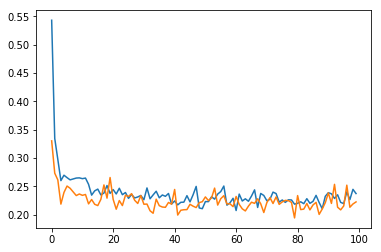

In [73]:
plt.plot(train_loss)
plt.plot(val_loss)

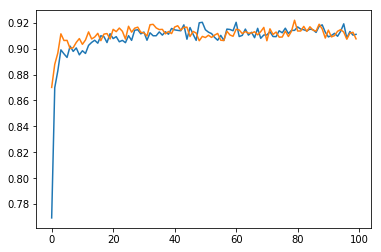

In [74]:
plt.plot(train_acc)
plt.plot(val_acc)

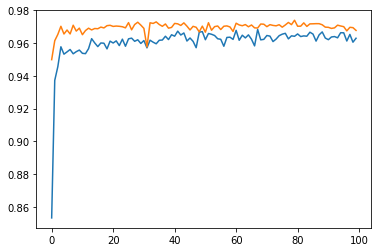

In [75]:
plt.plot(train_auc)
plt.plot(val_auc)

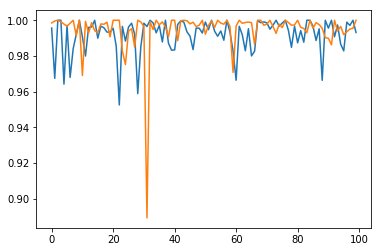

In [76]:
plt.plot(train_apatk)
plt.plot(val_apatk)

In [77]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_ts.as_matrix(),target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
    
    #pred_probas = normal_probas(pred_probas)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print("Scores:")
print('\tloss:',b_loss/b_c)
print('\tacc:',final_accuracy)
print('\tauc:',final_auc)
print('\tap@k:',final_apatk)
score(final_accuracy,final_auc,final_apatk)

Scores:
	loss: 0.211785413226
	acc: 0.913175
	auc: 0.969548435
	ap@k: 0.987555948329

AUC:
	Сойдёт, хотя можно ещё поднажать (ok)

Accuracy:
	Всё ок (ok)

Average precision at K:
	Отличный результат (good)
